# Acoustic localization using non-linear inversion (grid search)

## Purpose of this notebook
The purpose of this notebook is to show all the processing steps and python commands needed to localize an acoustic signal in three-dimensions (3D) using fully non-linear inversion. The example below uses data from the mobile audio-video array and corresponds to the localization results presented in figure 11 of the paper. Note that this notebook is only meant to be show the analysis process on a single example. For processing, a full deployment efficiently, the code should be slightly modified (i.e., removing all the plotting steps and looping through files automatically) and executed in a regular python file (.py). Details about the theory behind the detection and localization process can be found in the paper.

The analysis process is composed of 7 steps:
* Step 1: Importing all the necessary libraries
* Step 2: Defining and loading the configuration files
* Step 3: Finding data from all hydrophones
* Step 4: Running the automatic detector
* Step 5: Creating a 3D grid of simulated TDOAs
* Step 6: Localizing the detected signals
* Step 7: Saving the localization results

All the data and config files needed for this notebook are in the folder [./localization/mobile-array](https://github.com/xaviermouy/XAV-arrays/tree/main/localization/mobile-array).

## Step1: Importing all the necessary libraries
The libraries used for the processing include ecosound, pandas and matplotlib (for plotting). All scripts used for the automatic detection and localization steps are in the python files detection.py and localization.py, respectively. The python file in tools.py contains other non-specific functions used throughout the processing.

Before going through the notebook, you will need to install the library ecosound and ipympl. To do so, type the following:

In [ ]:
!pip install ecosound
!pip install ipympl

If you run this notebook on Google Colab, you will need to execute the commands above at the beginning of each session. If you run this notebook localy on your own machine, **you only need to do this once**. Once all the libraries are installed, you can import them:

In [1]:
%matplotlib widget 
import sys
sys.path.append(r'C:\Users\xavier.mouy\Documents\GitHub\ecosound') # Adds higher directory to python modules path.
import pandas as pd
import ecosound.core.tools
from ecosound.core.metadata import DeploymentInfo
import ecosound
import tools
import detection
import localization

## Step 2: Defining and loading the configuration files

Before starting the processing we need to define four configuration files that define some metadata, describe the configuration of the array, and define the parameters to use for the detection and localization. Once these configuration files are defined, they can be used for processing the entire deployment.

### Deployment metadata 
The first configration file is the deployment_info.csv. It defines the basic metadata about the deployment (recorder type, depths, coordinates, etc.). These metadata will be attached to the detection and localization results. Each line of the csv file define a separate channel/hydrophone. The field names should be relatively self-explanatory. To see the format to use, have a look at the example of deployment_info files used for the large array ([here](https://github.com/xaviermouy/XAV-arrays/blob/main/localization/large-array/deployment_info.csv)) and mobile array ([here](https://github.com/xaviermouy/XAV-arrays/blob/main/localization/mobile-array/deployment_info.csv)).

You need to define which deployment_info file to use,then you can load it and inspect that all the fields are filled correctly:

In [2]:
# config file
deployment_info_file = r'.\mobile-array\deployment_info.csv'

# load and display deployment metadata
Deployment = DeploymentInfo()
Deployment.read(deployment_info_file)
Deployment.data

,audio_channel_number,UTC_offset,sampling_frequency,bit_depth,mooring_platform_name,recorder_type,recorder_SN,hydrophone_model,hydrophone_SN,hydrophone_depth,location_name,location_lat,location_lon,location_water_depth,deployment_ID,deployment_date,recovery_date
0,0,-7,48000,24,mobile-XAV-array,SoundTrap-300,5147,HTI-96-MIN,1117006,0,Hornby-Island,49.490267,-124.667639,20,HI-201909,20190914T000000,20190919T000000
1,1,-7,48000,24,mobile-XAV-array,SoundTrap-300,5147,HTI-96-MIN,1117005,0,Hornby-Island,49.490267,-124.667639,20,HI-201909,20190914T000000,20190919T000000
2,2,-7,48000,24,mobile-XAV-array,SoundTrap-300,5147,HTI-96-MIN,1117008,0,Hornby-Island,49.490267,-124.667639,20,HI-201909,20190914T000000,20190919T000000
3,3,-7,48000,24,mobile-XAV-array,SoundTrap-300,5147,HTI-96-MIN,1117007,0,Hornby-Island,49.490267,-124.667639,20,HI-201909,20190914T000000,20190919T000000


### Hydrophones configuration

The second configration file is the hydrophones_config csv file. It defines for each hydrophone, the coordinates, the channel the data is recorded to, and the location (path) of the data. See the examples of hydrophones_config file for the large array ([here](https://github.com/xaviermouy/XAV-arrays/blob/main/localization/large-array/hydrophones_config_07-HI.csv)) and the mobile array ([here](https://github.com/xaviermouy/XAV-arrays/blob/main/localization/mobile-array/hydrophones_config_HI-201909.csv)). Note that the first channel starts at 0.

Let's define and load the hydrophones_config file for the mobile array:

In [3]:
# Define config file
hydrophones_config_file = r'.\mobile-array\hydrophones_config_HI-201909.csv'

# load and plot hydrophone configuration
hydrophones_config= pd.read_csv(hydrophones_config_file, skipinitialspace=True, dtype={'name': str, 'file_name_root': str}) # load hydrophone coordinates (meters)
hydrophones_config

,name,x,y,z,array_channel,audio_file_channel,data_path,file_name_root
0,Hydrophone 0,-0.46,0.00,0.00,0,0,.\mobile-array\data,671404070
1,Hydrophone 1,0.00,0.19,0.54,1,1,.\mobile-array\data,671404070
2,Hydrophone 2,0.00,0.49,0.00,2,2,.\mobile-array\data,671404070
3,Hydrophone 3,0.48,0.00,0.00,3,3,.\mobile-array\data,671404070


We can see that there is one row per hydrophone and 8 fields per row: 

* The **name** is a free field only used to label hydrophones in plots.
* The **x**, **y**, and **z** define the 3D coordinates of the hydrophones in meters. 
* The **array_channel** identifies which channel the hydrophone corresponds to. It must be consistent with the **audio_channel_number** values identified in the deployment_info file. 
* The **audio_file_channel** identifies which channel is used in the audio file. Some recorders (like the AMAR recorders) save data from each channel in separate mono wav files. In such case, the **audio_file_channel** is set to 0 (since each file has only 1 channel). Other recorders (like the Soundtrap recorders) save data from all channels in a single audio file. In such case, the channel to use in the audio file must be identified. In the present case, we use data from the mobile array, which saves data from each channel in a signgle multi-channel file. So we set the "audio_file_channel" to 0, 1, 2, and 3 for each hydrophones. 
* **file_name_root** defines the first part of the filenames for each hydrophone. It is assumed that the remaining part of the audio file contains the time stamp of the file. For data from AMAR recorders, the audio file names start with the serial number of the AMAR, a dot, the channel number, a dot, and the timestamp. So, the **file_name_root** is different for each hydrophone. For Soundtraps recorders, data from all hydrophones are saved in a single multi-channel file, so **file_name_root** is the same for all hydrophones.

To ensure that the hydrophone geometry makes sense, we can plot the hydrophoen locations:

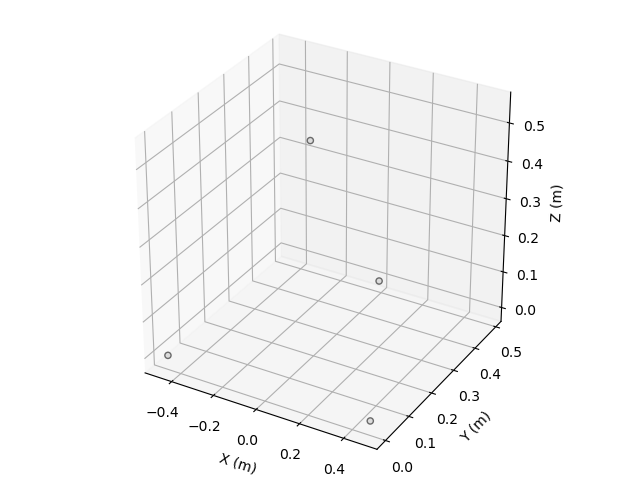

In [4]:
fig, ax = localization.plot_localizations3D(hydrophones=hydrophones_config)

### Detection parameters
The third configuration file to define is the detection file. It is a .yaml files defining the different parameters used during the detection process. It includes the spectrogram, denoising and detections parameters. A description of each parameter can be found in the paper. An example of detection config file can be found [here](https://github.com/xaviermouy/XAV-arrays/blob/main/localization/mobile-array/detection_config_mobile_array.yaml).

Let's define and load the detection config file:

In [5]:
# Define config files
detection_config_file = r'.\mobile-array\detection_config_mobile_array.yaml'

# load configuration parameters
detection_config = ecosound.core.tools.read_yaml(detection_config_file)
detection_config

{'AUDIO': {'channel': 2},
 'SPECTROGRAM': {'frame_sec': 0.0625,
  'nfft_sec': 0.0853,
  'step_sec': 0.01,
  'fmin_hz': 0,
  'fmax_hz': 1000,
  'window_type': 'hann',
  'dB': True,
  'use_dask': True,
  'dask_chunks': 40},
 'DENOISER': {'denoiser_name': 'median_equalizer',
  'window_duration_sec': 3,
  'use_dask': True,
  'dask_chunks': [2048, 2000]},
 'DETECTOR': {'detector_name': 'BlobDetector',
  'kernel_duration_sec': 0.05,
  'kernel_bandwidth_hz': 300,
  'threshold': 20,
  'duration_min_sec': 0.05,
  'bandwidth_min_hz': 40,
  'use_dask': True,
  'dask_chunks': [2048, 2000]}}

### localization parameters

The last configuration file is the localization file (.yaml) that defines the different parameters for the non-linear inversion. An example of localization config file can be found [here](https://github.com/xaviermouy/XAV-arrays/blob/main/localization/mobile-array/localization_config_mobile_array.yaml).

Let's define and load the localization config file:

In [6]:
localization_config_file = r'.\mobile-array\localization_config_mobile_array.yaml'
localization_config = ecosound.core.tools.read_yaml(localization_config_file)
localization_config

{'ENVIRONMENT': {'sound_speed_mps': 1484},
 'TDOA': {'ref_channel': 2,
  'upsample_res_sec': 1e-07,
  'normalize': False,
  'min_corr_val': 0.8},
 'GRIDSEARCH': {'x_limits_m': [-3, 3],
  'y_limits_m': [-3, 3],
  'z_limits_m': [-0.2, 3],
  'spacing_m': 0.02}}

Each parameter is explained below:
* **sound_speed_mps:** sound speed in the water, in meters per second
* **ref_channel:** reference channel for the TDOA measurements
* **upsample_res_sec:** time resolution desired for the cross correlation (in seconds)
* **min_corr_val:**  minimum correlation values accepted for considering a TDOA measurement valid
* **x_limits_m:** limits of the 3D grid along the x axis in meters (i.e., [min. x value, max. x value])
* **y_limits_m:** limits of the 3D grid along the y axis in meters (i.e., [min. y value, max. y value])
* **z_limits_m:** limits of the 3D grid along the z axis in meters (i.e., [min. z value, max. z value])
* **spacing_m:** spacing between each point of teh 3D grid, in meters.

## Step 3: Finding data from all hydrophones

We can now define the audio file we want to process. We can specify the name of a file from one hydrophone, and the code below will find out the corresponding files from the other hydrophones.

In [7]:
# Define file  to process
infile = r'.\mobile-array\data\671404070.190921010008.wav'

# Look up data files for all channels
audio_files = tools.find_audio_files(infile, hydrophones_config)

The variable **audio_files** now lists the path and name of the audio files from each hydrophone.

In [8]:
audio_files

{'path': ['.\\mobile-array\\data\\671404070.190921010008.wav',
  '.\\mobile-array\\data\\671404070.190921010008.wav',
  '.\\mobile-array\\data\\671404070.190921010008.wav',
  '.\\mobile-array\\data\\671404070.190921010008.wav'],
 'channel': [0, 1, 2, 3]}

We can then inspect the data from all channels by displaying the spectrograms and waveforms. The spectrogram parameters used for the spectrograms are the ones defined in the detection_config file defined earlier.

In [9]:
# plot all data 
graph_spectros, graph_waveforms = tools.plot_all_channels(audio_files,
                                                          detection_config['SPECTROGRAM']['frame_sec'],
                                                          detection_config['SPECTROGRAM']['window_type'],
                                                          detection_config['SPECTROGRAM']['nfft_sec'],
                                                          detection_config['SPECTROGRAM']['step_sec'],
                                                          detection_config['SPECTROGRAM']['fmin_hz'],
                                                          detection_config['SPECTROGRAM']['fmax_hz'],
                                                          detections_channel=detection_config['AUDIO']['channel'],
                                                          verbose=False)

#graph_spectros.show(display=False)
fig_graph_waveforms, ax_graph_waveforms = graph_waveforms.show(display=False)
fig_graph_spectros, ax_graph_spectros = graph_spectros.show(display=False)

Stacked spectrograms for all hydrophones:

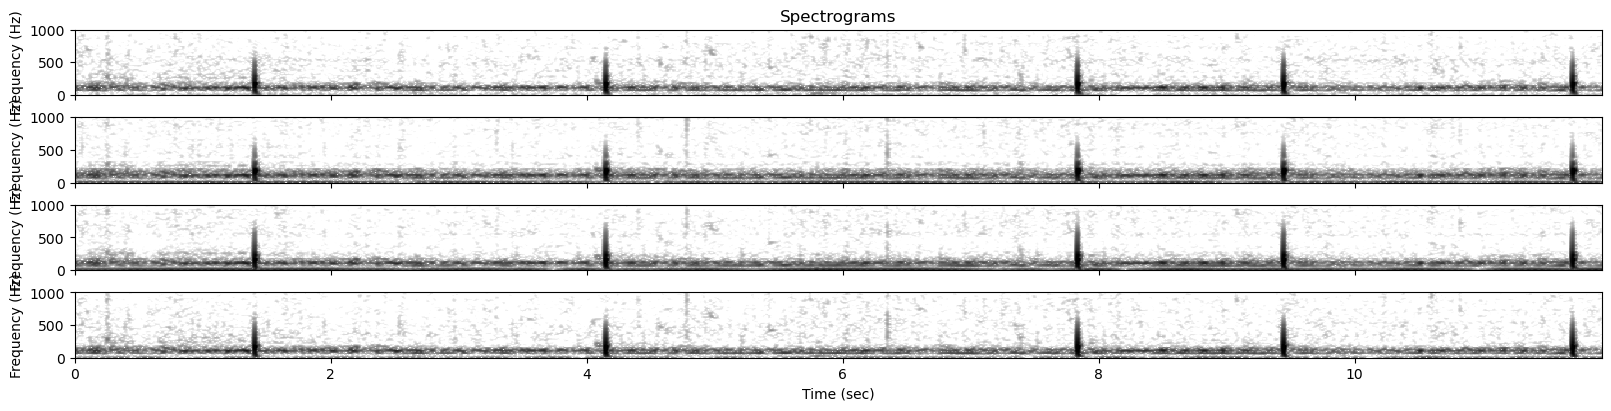

In [10]:
fig_graph_spectros

Stacked waveforms for all hydrophones:

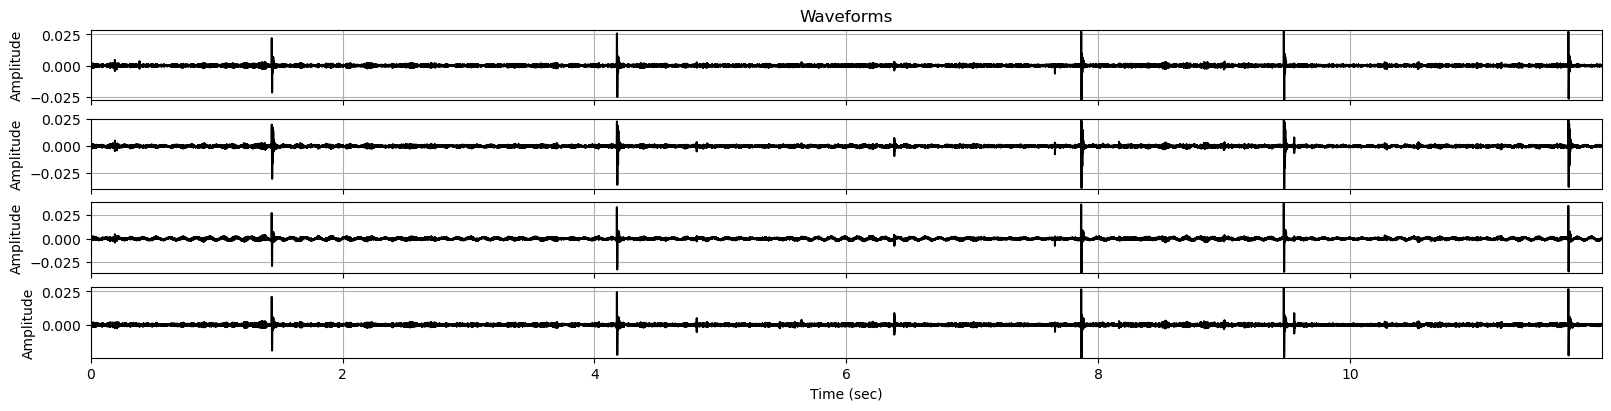

In [11]:
fig_graph_waveforms

## Step 4: Running the automatic detector

The detector can now be run on one of the hydrophones using the function **detection.run_detector**. The input arguments for that function are (in this order):
1. The path of the file to process, 
2. The channel to use,
3. the detection_config parameters (see step 2),
4. the path of the deployment_info file (see step 2). 

In [12]:
# run detector on selected channel
detections = detection.run_detector(audio_files['path'][detection_config['AUDIO']['channel']],
                                    audio_files['channel'][detection_config['AUDIO']['channel']],
                                    detection_config,
                                    deployment_file=deployment_info_file)

...done


The detector returns the variable **detections**, which is an ecosound annotation object. All detections can be found by accessing **detections.data**. The start and stop times of each detection are defined by the fields **time_min_offset** and **time_max_offset**, respectively. The minimum and maximum frequency of the detection boxes are defined by the fields **frequency_min** and **frequency_min**, respectively.

Here, we see that the algorithm found 14 detections:

In [13]:
# Look at detection table
detections.data

,uuid,from_detector,software_name,software_version,operator_name,UTC_offset,entry_date,audio_channel,audio_file_name,audio_file_dir,...,frequency_min,frequency_max,time_min_offset,time_max_offset,time_min_date,time_max_date,duration,label_class,label_subclass,confidence
0,b01a4752-61f6-4c33-bb2d-16d16593b9eb,True,BlobDetector,0.1,NECLWH01607755,-7,2022-10-05 16:12:31.889989,2,671404070.190921010008,.\mobile-array\data,...,152.34375,421.87500,0.24,0.28,2019-09-21 01:00:08.240,2019-09-21 01:00:08.280,0.04,NaN,NaN,NaN
1,5dc7daab-dd05-4960-ad4d-4899d98369f9,True,BlobDetector,0.1,NECLWH01607755,-7,2022-10-05 16:12:31.889989,2,671404070.190921010008,.\mobile-array\data,...,0.00000,843.75000,1.36,1.46,2019-09-21 01:00:09.360,2019-09-21 01:00:09.460,0.10,NaN,NaN,NaN
2,36161205-3dd4-4690-a728-f03916e1c3b2,True,BlobDetector,0.1,NECLWH01607755,-7,2022-10-05 16:12:31.889989,2,671404070.190921010008,.\mobile-array\data,...,35.15625,328.12500,2.18,2.22,2019-09-21 01:00:10.180,2019-09-21 01:00:10.220,0.04,NaN,NaN,NaN
3,4461320f-2727-480c-809c-3498c53f21e4,True,BlobDetector,0.1,NECLWH01607755,-7,2022-10-05 16:12:31.889989,2,671404070.190921010008,.\mobile-array\data,...,0.00000,843.75000,4.06,4.21,2019-09-21 01:00:12.060,2019-09-21 01:00:12.210,0.15,NaN,NaN,NaN
4,f70ef792-d86d-4327-84d0-373405118ab9,True,BlobDetector,0.1,NECLWH01607755,-7,2022-10-05 16:12:31.889989,2,671404070.190921010008,.\mobile-array\data,...,550.78125,1007.81250,4.76,4.81,2019-09-21 01:00:12.760,2019-09-21 01:00:12.810,0.05,NaN,NaN,NaN
5,8be036f2-d8f4-4961-9889-e782be9aa040,True,BlobDetector,0.1,NECLWH01607755,-7,2022-10-05 16:12:31.889989,2,671404070.190921010008,.\mobile-array\data,...,503.90625,832.03125,4.94,5.00,2019-09-21 01:00:12.940,2019-09-21 01:00:13.000,0.06,NaN,NaN,NaN
6,0e862bd3-6639-4ee0-9baf-4a800df26784,True,BlobDetector,0.1,NECLWH01607755,-7,2022-10-05 16:12:31.889989,2,671404070.190921010008,.\mobile-array\data,...,281.25000,574.21875,5.42,5.47,2019-09-21 01:00:13.420,2019-09-21 01:00:13.470,0.05,NaN,NaN,NaN
7,10c5e56e-eb97-4eed-a208-4f2a59a204f7,True,BlobDetector,0.1,NECLWH01607755,-7,2022-10-05 16:12:31.889989,2,671404070.190921010008,.\mobile-array\data,...,187.50000,796.87500,6.32,6.38,2019-09-21 01:00:14.320,2019-09-21 01:00:14.380,0.06,NaN,NaN,NaN
8,688dab48-836b-47c0-852c-de6222c788de,True,BlobDetector,0.1,NECLWH01607755,-7,2022-10-05 16:12:31.889989,2,671404070.190921010008,.\mobile-array\data,...,164.06250,468.75000,7.36,7.41,2019-09-21 01:00:15.360,2019-09-21 01:00:15.410,0.05,NaN,NaN,NaN
9,0e25a1dc-d504-45b2-80ea-409553593f76,True,BlobDetector,0.1,NECLWH01607755,-7,2022-10-05 16:12:31.889989,2,671404070.190921010008,.\mobile-array\data,...,0.00000,878.90625,7.78,7.89,2019-09-21 01:00:15.780,2019-09-21 01:00:15.890,0.11,NaN,NaN,NaN


We can inspect the detections by ploting their time and frequency boxes on top of the spectrogram and waveform:

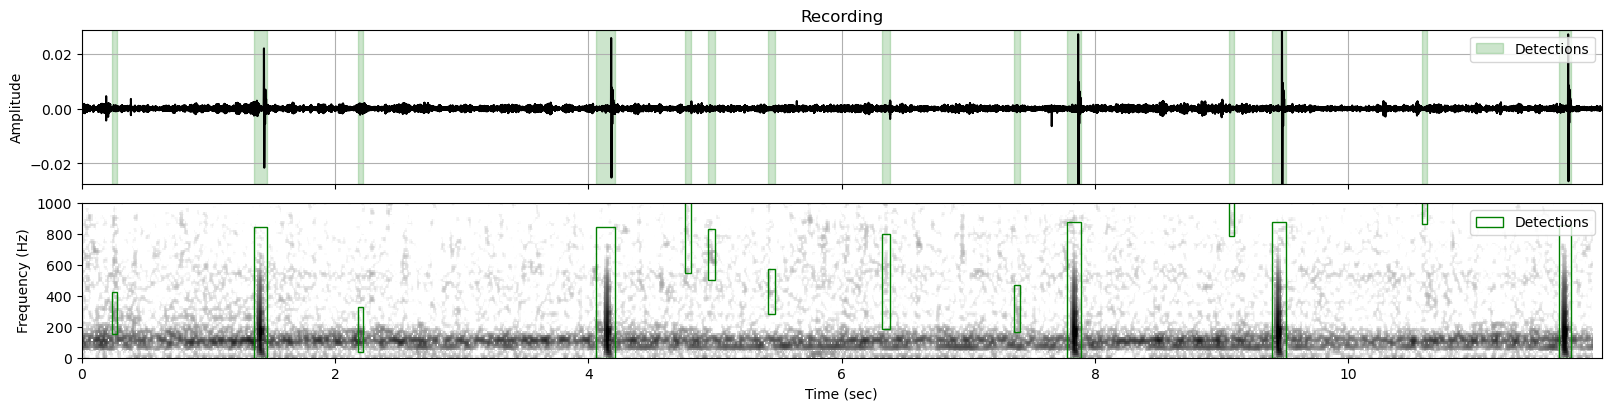

In [14]:
# plot detections
graph_detec = tools.plot_single_channel(audio_files['path'][detection_config['AUDIO']['channel']],
                                  detection_config['SPECTROGRAM']['frame_sec'],
                                  detection_config['SPECTROGRAM']['window_type'],
                                  detection_config['SPECTROGRAM']['nfft_sec'],
                                  detection_config['SPECTROGRAM']['step_sec'],
                                  detection_config['SPECTROGRAM']['fmin_hz'],
                                  detection_config['SPECTROGRAM']['fmax_hz'],
                                  detections=detections,
                                  verbose=False)
fig_graph_detec, ax_graph_detec = graph_detec.show(display=False)
fig_graph_detec

## Step 5: Creating a 3D grid of simulated TDOAs

Using the function **localization.GridSearch.create_tdoa_grid**, we can compute simulated TDOAs on a 3D grid around the hydrophones. This grid only needs to be computed once and save on the disk as a .npz file.

Input arguments of the function **localization.GridSearch.create_tdoa_grid** are:
1. limits of the grid along the x axis,
2. limits of the grid along the y axis,
3. limits of the grid along the z axis,
4. spacing between points of the grid,
5. the hydrophone configuration,
6. the refrence hydrophone for the TDOAs,
7. the sound speed,
8. the path and name of the .npz file that will be created to save the TDOA grid.

Most of these parameters are taken directly from the localization configuration file (see step 2).

In [15]:
# create 3D grid of TDOAs
tdoa_grid_file = r'./mobile-array/tdoa_grid.npz'
localization.GridSearch.create_tdoa_grid(localization_config['GRIDSEARCH']['x_limits_m'],
                                            localization_config['GRIDSEARCH']['y_limits_m'],
                                            localization_config['GRIDSEARCH']['z_limits_m'],
                                            localization_config['GRIDSEARCH']['spacing_m'],
                                            hydrophones_config,
                                            localization_config['TDOA']['ref_channel'],
                                            localization_config['ENVIRONMENT']['sound_speed_mps'],
                                            tdoa_grid_file)

...done


Now that the TDOA grid file is created, we need to load it:

In [16]:
# load grid of precomputed TDOAs
tdoa_grid = localization.GridSearch.load_tdoa_grid(tdoa_grid_file)

## Step 6: Localizing the detected signals

Now we can localize the detected signals using non-linear inversion. The code below may take several seconds.

In [17]:
# Perform localization using grid search
localizations, PPDs = localization.GridSearch.run_localization(audio_files, detections, tdoa_grid, deployment_info_file, detection_config, hydrophones_config, localization_config, verbose=False)

Issue while calculating the CI
...done


The localization results are in the **localizations** variable. It contains the same number of rows as the variable **detections**. Localization details can be found in **localizations.data**, and the localization fileds are as follows:
* **x**, **y**, and **z** define the coordinates of the localizations
* **x_err_low** and **x_err_high**, **y_err_low** and **y_err_high**,and **z_err_low** and **z_err_high** are the low and high localization uncertainties for each dimension.
* **x_err_span**, **y_err_span**, and **z_err_span** define the span of the uncertainties in each dimension (i.e., x_err_span = x_err_high - x_err_low).

In [18]:
localizations.data

,uuid,from_detector,software_name,software_version,operator_name,UTC_offset,entry_date,audio_channel,audio_file_name,audio_file_dir,...,x_err_low,x_err_high,x_err_span,y_err_low,y_err_high,y_err_span,z_err_low,z_err_high,z_err_span,tdoa_errors_std
0,b01a4752-61f6-4c33-bb2d-16d16593b9eb,True,BlobDetector,0.1,NECLWH01607755,-7,2022-10-05 16:12:31.889989,2,671404070.190921010008,.\mobile-array\data,...,-0.14,0.06,0.2,-0.12,0.1,0.22,-0.12,0.16,0.28,0.000088
1,5dc7daab-dd05-4960-ad4d-4899d98369f9,True,BlobDetector,0.1,NECLWH01607755,-7,2022-10-05 16:12:31.889989,2,671404070.190921010008,.\mobile-array\data,...,-0.06,0.24,0.3,0.32,1.06,0.74,-0.2,-0.08,0.12,0.000088
2,36161205-3dd4-4690-a728-f03916e1c3b2,True,BlobDetector,0.1,NECLWH01607755,-7,2022-10-05 16:12:31.889989,2,671404070.190921010008,.\mobile-array\data,...,-2.84,0.94,3.78,-2.14,0.96,3.1,-0.2,2.62,2.82,0.000088
3,4461320f-2727-480c-809c-3498c53f21e4,True,BlobDetector,0.1,NECLWH01607755,-7,2022-10-05 16:12:31.889989,2,671404070.190921010008,.\mobile-array\data,...,-0.08,0.28,0.36,0.28,1.16,0.88,-0.2,-0.1,0.1,0.000088
4,f70ef792-d86d-4327-84d0-373405118ab9,True,BlobDetector,0.1,NECLWH01607755,-7,2022-10-05 16:12:31.889989,2,671404070.190921010008,.\mobile-array\data,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,8be036f2-d8f4-4961-9889-e782be9aa040,True,BlobDetector,0.1,NECLWH01607755,-7,2022-10-05 16:12:31.889989,2,671404070.190921010008,.\mobile-array\data,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0e862bd3-6639-4ee0-9baf-4a800df26784,True,BlobDetector,0.1,NECLWH01607755,-7,2022-10-05 16:12:31.889989,2,671404070.190921010008,.\mobile-array\data,...,0.18,2.54,2.36,-1.52,0.74,2.26,-0.2,0.68,0.88,0.000088
7,10c5e56e-eb97-4eed-a208-4f2a59a204f7,True,BlobDetector,0.1,NECLWH01607755,-7,2022-10-05 16:12:31.889989,2,671404070.190921010008,.\mobile-array\data,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,688dab48-836b-47c0-852c-de6222c788de,True,BlobDetector,0.1,NECLWH01607755,-7,2022-10-05 16:12:31.889989,2,671404070.190921010008,.\mobile-array\data,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0e25a1dc-d504-45b2-80ea-409553593f76,True,BlobDetector,0.1,NECLWH01607755,-7,2022-10-05 16:12:31.889989,2,671404070.190921010008,.\mobile-array\data,...,-0.02,0.26,0.28,0.32,0.96,0.64,-0.2,-0.1,0.1,0.000088


We can filter the localizations and only keep the ones that are in the field of view of the camera. 

In [19]:
# Filter localization results
localizations.filter("y > 0.3", inplace=True)

Measurement object (5)

Now, visualizing which localized sounds are remaining:

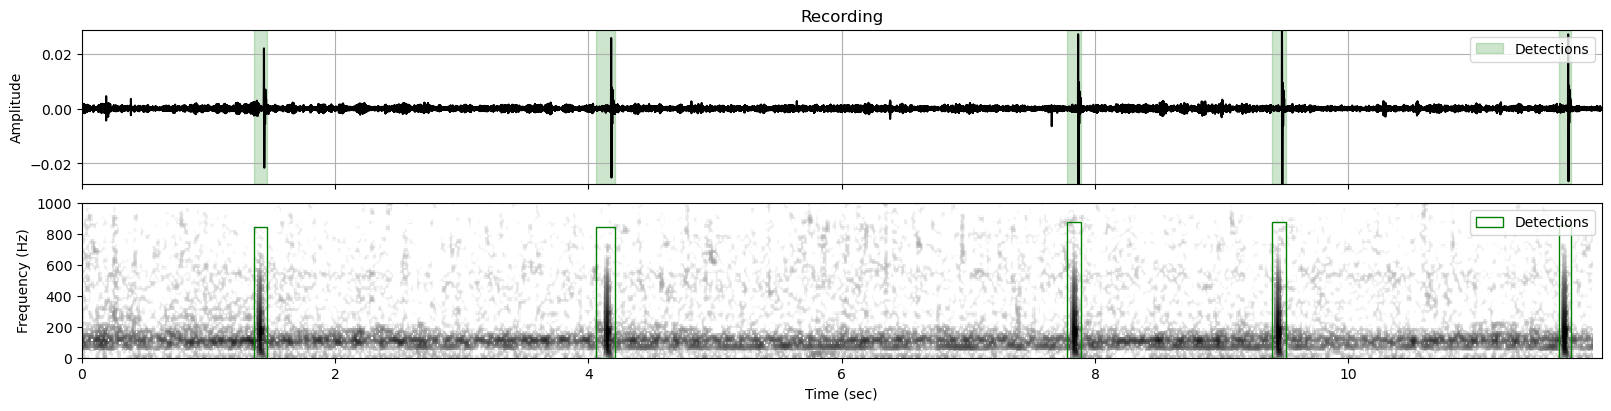

In [20]:
# plot spectrogram with measurements filtered
graph_loc = tools.plot_single_channel(audio_files['path'][detection_config['AUDIO']['channel']],
                                      detection_config['SPECTROGRAM']['frame_sec'],
                                      detection_config['SPECTROGRAM']['window_type'],
                                      detection_config['SPECTROGRAM']['nfft_sec'],
                                      detection_config['SPECTROGRAM']['step_sec'],
                                      detection_config['SPECTROGRAM']['fmin_hz'],
                                      detection_config['SPECTROGRAM']['fmax_hz'],
                                      detections=localizations,
                                      verbose=False)
fig_graph_loc, ax_graph_loc = graph_loc.show(display=False)
fig_graph_loc

Finally, we can visualize the localizations (blue dots) with their unceratinties (red bars) in a 3D scatter plot:

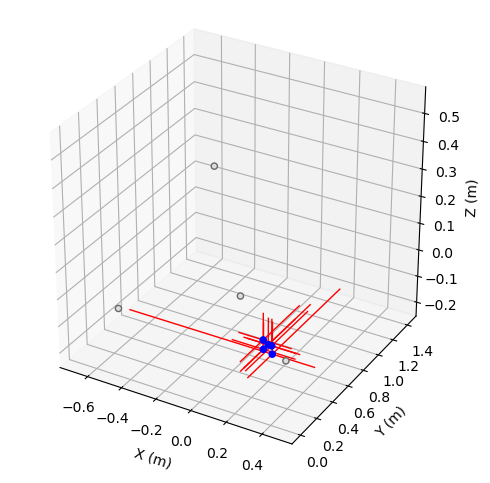

In [21]:
# Plot localizations
fig_loc, fig_ax = localization.plot_localizations3D(localizations=localizations, hydrophones=hydrophones_config)
fig_loc

## Step 7: Saving the localization results
The loclaization results can be saved to a csv file and/or a netcdf file that can be used later on by ecosound:

In [ ]:
# save as csv:
localizations.to_csv('localization_results.csv')

# save as netcdf
localizations.to_netcdf('localization_results.nc')